In [2]:
import os
import cv2

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def load_data(images_path, masks_path):
    images = []
    masks = []
    
    for img_name in os.listdir(images_path):
        img = cv2.imread(os.path.join(images_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))  # Изменяем размер
        img = img / 255.0  # Нормализация
        images.append(img)

        mask_name = img_name
        mask = cv2.imread(os.path.join(masks_path, mask_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.float32)  # Бинаризация
        masks.append(mask)

    return np.array(images), np.array(masks)


In [4]:
def plot_results(original_images, true_masks, predicted_masks, num=5):
    plt.figure(figsize=(20, 13))

    for i in range(num):
        idx = np.random.randint(len(original_images))
        plt.subplot(4, num, i + 1)
        plt.imshow(original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(4, num, i + num + 1)
        plt.imshow(true_masks[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(4, num, i + 2 * num + 1)
        plt.imshow((predicted_masks[idx] > 0.5).astype(np.float32), cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")
        
        plt.subplot(4, num, i + 3 * num + 1)
        plt.imshow(predicted_masks[idx] * original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted image")

    plt.show()

In [5]:
X, Y = load_data("images_nail", "labels_nail")

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        bce = binary_crossentropy(y_true, y_pred)

        return tf.reduce_mean(bce * weights)
    return loss

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
model_fc = keras.Sequential([
    layers.Flatten(input_shape=(256, 256, 3)),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256 * 256, activation='sigmoid'),  # Выход в виде плоского массива
    layers.Reshape((256, 256, 1))  # Обратное преобразование в сегментацию
])
model_fc.compile(optimizer='adam', loss=weighted_binary_crossentropy(100), metrics=['accuracy', 'precision'])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model_fc.fit(datagen.flow(X_train, Y_train, batch_size=10), 
            validation_data=(X_val, Y_val),
            epochs=20)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.5730 - loss: 81.6312 - precision: 0.2117 - val_accuracy: 0.6693 - val_loss: 62.3034 - val_precision: 0.1866
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6741 - loss: 63.2853 - precision: 0.3142 - val_accuracy: 0.7880 - val_loss: 53.7690 - val_precision: 0.2372
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7070 - loss: 61.0438 - precision: 0.3024 - val_accuracy: 0.8036 - val_loss: 51.9668 - val_precision: 0.2857
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.7651 - loss: 56.1673 - precision: 0.3225 - val_accuracy: 0.7804 - val_loss: 54.5844 - val_precision: 0.1919
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7353 - loss: 57.9277 - precision: 0.3434 - val_accuracy: 0.8043 - val_loss: 52.4525 - val_precision: 0.2728
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7477 - loss: 57.2223 - precision: 0.4152 - val_accuracy: 0.8114 - val_loss: 51.8956 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


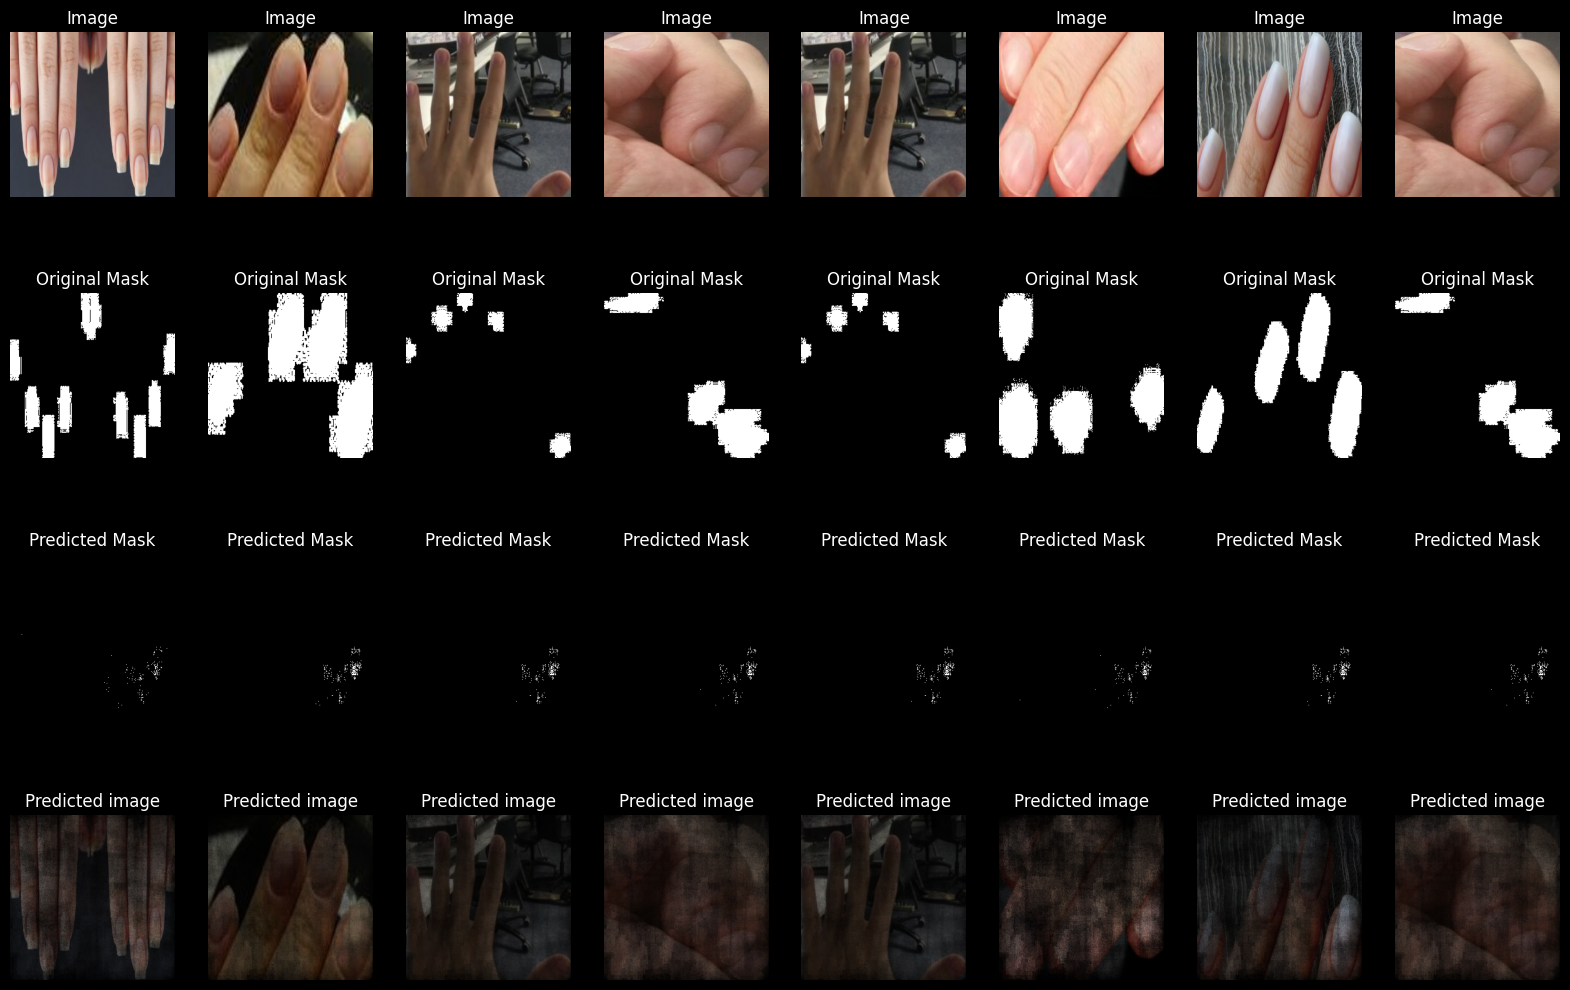

In [11]:
Y_pred = model_fc.predict(X_val)
# Визуализируем первые 5 изображений из валидационной выборки
plot_results(X_val, Y_val, Y_pred, num=8)

In [12]:
Y_pred = (Y_pred > 0.5).astype(np.float32)
# Вычисление метрик
accuracy = np.mean(Y_pred.flatten() == Y_val.flatten())
precision = precision_score(Y_val.flatten(), Y_pred.flatten())
recall = recall_score(Y_val.flatten(), Y_pred.flatten())

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Accuracy: 0.8133, Precision: 0.3474, Recall: 0.0069


In [13]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Энергия спуска
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Декодирование
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Используйте softmax, если у вас больше классов
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [14]:
model_unet = unet_model((256, 256, 3))
model_unet.compile(optimizer='adam', loss=weighted_binary_crossentropy(100), metrics=['accuracy', 'precision'])

In [16]:
model_unet.fit(datagen.flow(X_train, Y_train, batch_size=10), validation_data=(X_val, Y_val), epochs=5)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 98s 18s/step - accuracy: 0.7661 - loss: 60.7480 - precision: 0.0000e+00 - val_accuracy: 0.8144 - val_loss: 61.1936 - val_precision: 0.0000e+00
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 18s/step - accuracy: 0.7372 - loss: 62.0290 - precision: 0.0000e+00 - val_accuracy: 0.8144 - val_loss: 53.0916 - val_precision: 0.0000e+00
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 96s 19s/step - accuracy: 0.7508 - loss: 58.1269 - precision: 0.0000e+00 - val_accuracy: 0.8144 - val_loss: 52.0619 - val_precision: 0.0000e+00
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 115s 23s/step - accuracy: 0.7582 - loss: 57.1709 - precision: 0.0000e+00 - val_accuracy: 0.8144 - val_loss: 51.9004 - val_precision: 0.0000e+00
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 152s 30s/step - accuracy: 0.7678 - loss: 55.2986 - precision: 0.0000e+00 - val_accuracy: 0.8144 - val_loss: 50.4294 - val_precision: 0.0000e+00


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


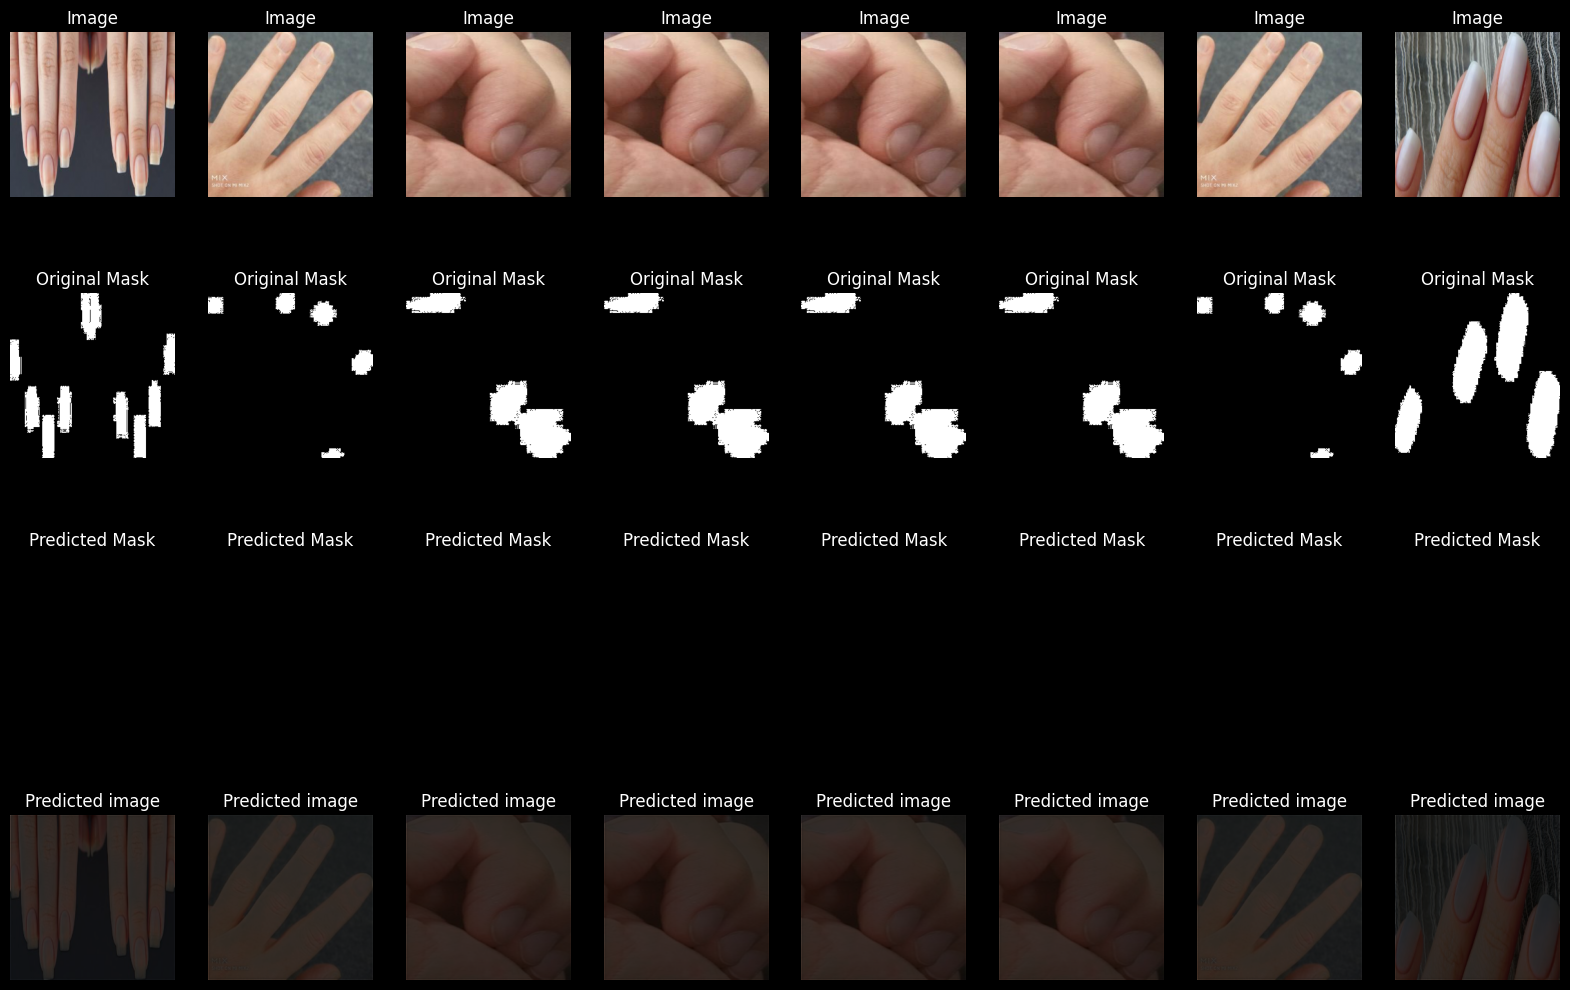

In [17]:
# Предсказание на валидационных данных
Y_pred = model_unet.predict(X_val)
plot_results(X_val, Y_val, Y_pred, num=8)

In [18]:
Y_pred = (Y_pred > 0.5).astype(np.float32)
# Вычисление метрик
accuracy = np.mean(Y_pred.flatten() == Y_val.flatten())
precision = precision_score(Y_val.flatten(), Y_pred.flatten())
recall = recall_score(Y_val.flatten(), Y_pred.flatten())

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Accuracy: 0.8144, Precision: 0.0000, Recall: 0.0000


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
